# Classifications - Use maching learning models to predict ratings from review text

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
ratings = pd.read_csv("cleaned_reviews.csv")

In [3]:
print(ratings.shape)
ratings.head()

(1071351, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [4]:
ratings["rating"].value_counts(normalize=True)

5    0.761869
4    0.174857
3    0.038131
2    0.013181
1    0.011962
Name: rating, dtype: float64

In [5]:
# Building Pipeline for raw text transformation and model tuning
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('classifier', MultinomialNB(
                    fit_prior=True, class_prior=None)),
    ])

In [6]:
#Train and Test data split for the ratings classification model.
X_train, X_test, y_train, y_test = train_test_split(ratings["review"]
                                                    , ratings["rating"],random_state = 42, 
                                                    stratify= ratings["rating"],
                                                   test_size = 0.20)

In [7]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((857080,), (214271,), (857080,), (214271,))

In [8]:
model = clf.fit(X_train , y_train)

In [9]:
model.score(X_train,y_train)

0.7892833807812573

In [10]:
model.score(X_test,y_test)

0.7756439275496917

In [11]:
pred = model.predict(X_test)

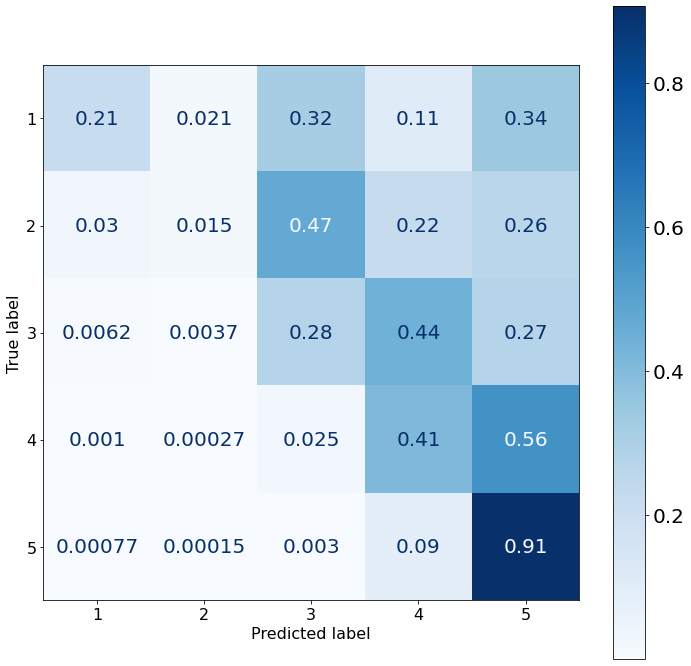

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', normalize = 'true', ax=ax);

In [14]:
import time
# GradientBoost Model

model_pipeline = Pipeline([
    ("vec", TfidfVectorizer()),
    ("gb", GradientBoostingClassifier(random_state=42))
])

#the pipe params are a dict that the user enters into the function
model_pipe_params = {
    "gb__learning_rate" : [.05],
    "gb__n_estimators" : [100],
    "gb__min_samples_leaf" : [4],
    "gb__max_depth" : [4],
    'vec__max_features': [3000],
    'vec__min_df': [2],
    'vec__max_df': [.85],
    'vec__ngram_range': [(1,1)],
    'vec__stop_words': ["english"]
}

#start a timer
t0 = time.time()

gb_gs = GridSearchCV(model_pipeline,param_grid=model_pipe_params,cv=2,verbose=1)

#fit the data
gb_gs.fit(X_train,y_train)
t1 = time.time()
print(f'This took {t1-t0} seconds!')

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 156.1min finished


This took 21254.29694390297 seconds!


In [17]:
# convert seconds to hours. It takes too long to run
21254.29694390297/3600

5.903971373306381

In [15]:
 #save the best estimator
best_gb = gb_gs.best_estimator_


print(f'best training score: {best_gb.score(X_train, y_train)}')
preds = best_gb.predict(X_train)
# print(f'best training recall: {recall_score(y_train,preds)}')
print(f'best testing score: {best_gb.score(X_test, y_test)}')

best training score: 0.7824707145190647
best testing score: 0.7811603063410354


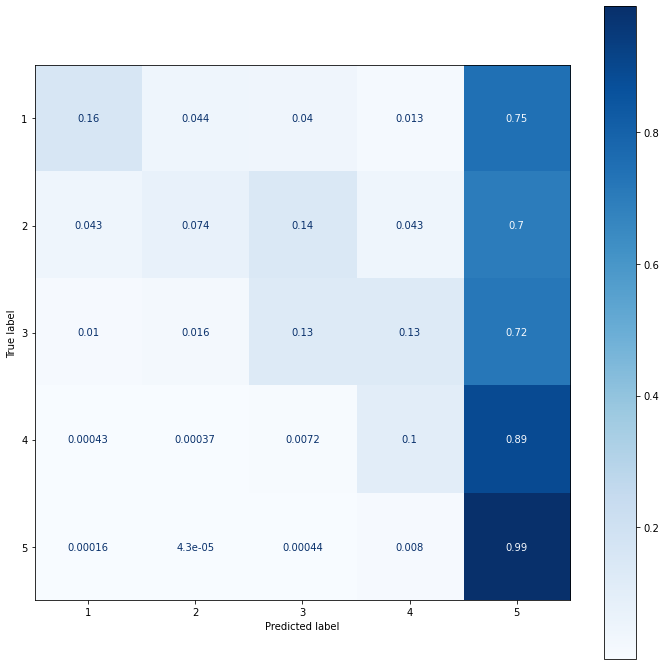

In [16]:
#confusion matrix of GradientBoost model
fig, ax = plt.subplots(figsize=(12, 12));
plot_confusion_matrix(best_gb, X_test, y_test, cmap = 'Blues', normalize = 'true', ax=ax);

# Further Study with Logistric Regression for Rating score 5 reviews

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [15]:
# Assign rating "5" as "1",  and rating "1 to 4" as "0"
ratings["new_rating"] = np.where(ratings["rating"]==5, 1, 0)

In [16]:
ratings["new_rating"].mean()

0.7618688926411605

In [17]:
X_train, X_test, y_train, y_test = train_test_split(ratings["review"]
                                                    , ratings["new_rating"],random_state = 42, 
                                                    stratify= ratings["new_rating"],
                                                   test_size = 0.20)

vectorizer = TfidfVectorizer(max_df=0.85, max_features=3000, min_df=2, stop_words='english')
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [18]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print(f'training score: {logreg.score(X_train, y_train)}')
print(f'testing score: {logreg.score(X_test, y_test)}')
print(f'Intercept: {logreg.intercept_}')
print(f'Coefficient: {logreg.coef_}')
print(f'Exponentiated Coefficient: {np.exp(logreg.coef_)}')

training score: 0.8370595510337425
testing score: 0.8348586602946736
Intercept: [0.24141546]
Coefficient: [[ 0.1601326  -0.9273322  -0.82610132 ...  1.82321201  1.74159317
   2.36374441]]
Exponentiated Coefficient: [[ 1.17366649  0.39560771  0.43775262 ...  6.19171439  5.70642747
  10.63068266]]


In [19]:
preds = logreg.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
# Calculate the specificity

spec = tn / (tn + fp)
sens = tp /(tp + fn)
acc = (tp + tn)/(tn + fp + fn + tp)

print('Accuracy:', acc)
print('Specificity:', spec)
print('Sensitivity:', sens)

Accuracy: 0.8348586602946736
Specificity: 0.4761391474767271
Sensitivity: 0.9469818556044253


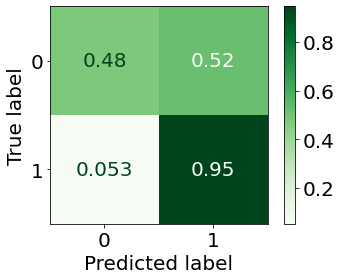

In [20]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Greens', normalize='true');

In [21]:
# Creating a DataFrame of Predicted Probabilities
pred_proba = [i[1] for i in logreg.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

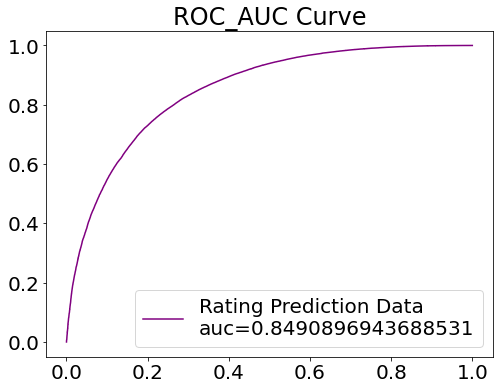

In [22]:
# Adapted from "https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python"
fpr, tpr, _ = metrics.roc_curve(pred_df['true_values'], pred_df['pred_probs'])
auc = metrics.roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="Rating Prediction Data\nauc="+str(auc), color='purple')
plt.title('ROC_AUC Curve')
plt.legend(loc=4)
plt.show()

In [23]:
coef_table = pd.DataFrame(data=vectorizer.get_feature_names(), columns=['Words']).copy()
coef_table.insert(len(coef_table.columns),"Coefficients", (logreg.coef_[0]).transpose())

In [24]:
top_negtive_betas = coef_table.set_index('Words').sort_values(by='Coefficients', ascending=True).head(20)
top_positive_betas = coef_table.set_index('Words').sort_values(by='Coefficients', ascending=False).head(20)

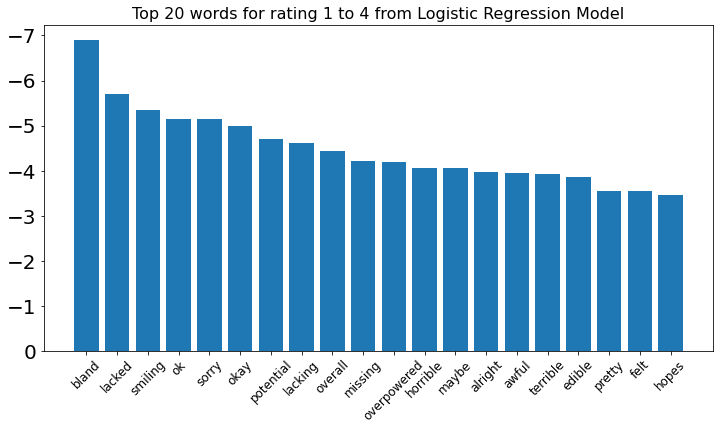

In [31]:
plt.figure(figsize=(12, 6))

# visualize top 20 negative beta
plt.bar(top_negtive_betas.index, top_negtive_betas['Coefficients'])
plt.title('Top 20 words for rating 1 to 4 from Logistic Regression Model', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.gca().invert_yaxis();

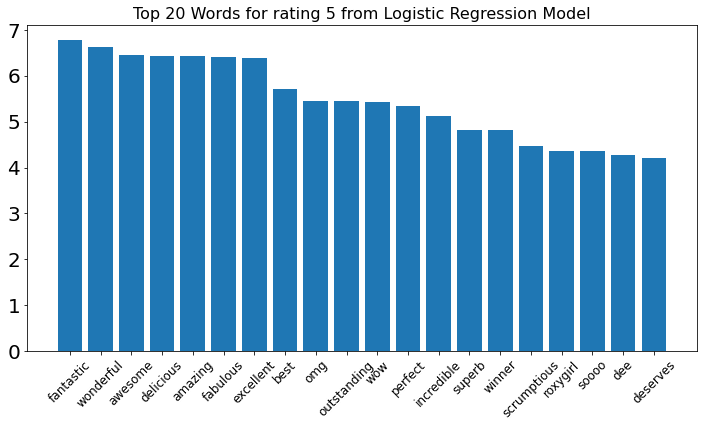

In [30]:
plt.figure(figsize=(12, 6))

# visualize top 20 negative beta
plt.bar(top_positive_betas.index, top_positive_betas['Coefficients'])
plt.title('Top 20 Words for rating 5 from Logistic Regression Model', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.xticks(rotation=45);